In [1]:
# %%
# ========================================
# CELL 1: INSTALL & IMPORT
# ========================================

# !pip install -q transformers==4.36.0 peft==0.7.1 datasets==2.16.1 accelerate==0.25.0 sentencepiece bitsandbytes sacrebleu rouge-score

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    T5ForConditionalGeneration, 
    T5Tokenizer,
    MT5ForConditionalGeneration,
    MT5Tokenizer,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    TrainingArguments, 
    Trainer,
    DataCollatorForSeq2Seq,
)
from transformers.modeling_outputs import BaseModelOutput
from peft import LoraConfig, get_peft_model, TaskType
from datasets import Dataset
import os
import json
import math
import numpy as np
import warnings
import gc
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import Counter

warnings.filterwarnings('ignore')
torch.cuda.empty_cache()

print(f"✅ PyTorch: {torch.__version__}")
print(f"✅ CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✅ VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"✅ Compute Capability: {torch.cuda.get_device_capability(0)}")

2025-11-27 08:52:42.474226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764233562.668707      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764233562.719237      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

✅ PyTorch: 2.6.0+cu124
✅ CUDA Available: True
✅ GPU: Tesla P100-PCIE-16GB
✅ VRAM: 17.06 GB
✅ Compute Capability: (6, 0)


In [2]:
# %%
# ========================================
# CELL 2: GLOBAL CONFIGURATION
# ========================================

class Config:
    # ✅ TEST MODE - Bật để test nhanh
    TEST_MODE = True  # ← SET TRUE ĐỂ TEST
    
    # Paths
    DATA_DIR = "/kaggle/input/processed-data"
    OUTPUT_DIR = "/kaggle/working/models"
    
    # ✅ Training params - Dynamic based on TEST_MODE
    if TEST_MODE:
        print("⚡ TEST MODE ENABLED - Fast Training")
        NUM_EPOCHS = 3
        MAX_INPUT_LENGTH = 128
        MAX_TARGET_LENGTH = 64
        TRAIN_SAMPLES = 100000
        VAL_SAMPLES = 200
        TEST_SAMPLES = 100
        EVAL_STEPS = 50
        SAVE_STEPS = 50
        LOGGING_STEPS = 10
    else:
        print("🔥 FULL TRAINING MODE")
        NUM_EPOCHS = 3
        MAX_INPUT_LENGTH = 256
        MAX_TARGET_LENGTH = 128
        TRAIN_SAMPLES = None
        VAL_SAMPLES = None
        TEST_SAMPLES = None
        EVAL_STEPS = 200
        SAVE_STEPS = 200
        LOGGING_STEPS = 50
    
    # Model configs - 3 MODELS KHÁC NHAU
    MODELS = {
        # Model 1: ViT5-Base với Advanced Architecture (CODE CŨ)
        "vit5-base": {
            "name": "VietAI/vit5-base",
            "type": "t5-advanced",
            "batch_size": 32 if TEST_MODE else 16,
            "learning_rate": 2e-4 if TEST_MODE else 1e-4,
            "gradient_accumulation": 1 if TEST_MODE else 2,
            "lora_r": 16 if TEST_MODE else 32,
            "lora_alpha": 32 if TEST_MODE else 64,
        },
        
        # Model 2: BARTpho - THAY THẾ GPT-Neo
        "bartpho": {
            "name": "vinai/bartpho-syllable",  # Hoặc "vinai/bartpho-word"
            "type": "bart",
            "batch_size": 16 if TEST_MODE else 8,
            "learning_rate": 2e-4 if TEST_MODE else 1e-4,
            "gradient_accumulation": 2 if TEST_MODE else 4,
            "lora_r": 16 if TEST_MODE else 32,
            "lora_alpha": 32 if TEST_MODE else 64,
        },
        
        # Model 3: mT5-Base Vanilla
        "mt5-base": {
            "name": "google/mt5-base",
            "type": "mt5-simple",
            "batch_size": 24 if TEST_MODE else 12,
            "learning_rate": 1e-4 if TEST_MODE else 5e-5,
            "gradient_accumulation": 1 if TEST_MODE else 3,
            "lora_r": 16 if TEST_MODE else 32,
            "lora_alpha": 32 if TEST_MODE else 64,
        }
    }


config = Config()
os.makedirs(config.OUTPUT_DIR, exist_ok=True)

print("=" * 80)
print("📋 COMPARISON: 3 DIFFERENT MODELS FOR VIETNAMESE")
print("=" * 80)
for name, cfg in config.MODELS.items():
    print(f"\n{name}:")
    print(f"  Model: {cfg['name']}")
    print(f"  Type: {cfg['type']}")
    print(f"  Batch: {cfg['batch_size']} × {cfg['gradient_accumulation']} = {cfg['batch_size'] * cfg['gradient_accumulation']}")
print("=" * 80)


⚡ TEST MODE ENABLED - Fast Training
📋 COMPARISON: 3 DIFFERENT MODELS FOR VIETNAMESE

vit5-base:
  Model: VietAI/vit5-base
  Type: t5-advanced
  Batch: 32 × 1 = 32

bartpho:
  Model: vinai/bartpho-syllable
  Type: bart
  Batch: 16 × 2 = 32

mt5-base:
  Model: google/mt5-base
  Type: mt5-simple
  Batch: 24 × 1 = 24


In [3]:
# %%
# ========================================
# CELL 3: LOAD DATA
# ========================================

def load_data():
    print("=" * 70)
    print("📂 LOADING DATA")
    print("=" * 70)
    
    train_df = pd.read_csv(f"{config.DATA_DIR}/train.csv")
    val_df = pd.read_csv(f"{config.DATA_DIR}/val.csv")
    test_df = pd.read_csv(f"{config.DATA_DIR}/test.csv")
    
    # Clean
    for df in [train_df, val_df, test_df]:
        df.dropna(subset=['input_text', 'target_text'], inplace=True)
        df['input_text'] = df['input_text'].str.strip()
        df['target_text'] = df['target_text'].str.strip()
    
    # ✅ SAMPLE DATA IN TEST MODE
    if config.TEST_MODE:
        train_df = train_df.head(config.TRAIN_SAMPLES)
        val_df = val_df.head(config.VAL_SAMPLES)
        test_df = test_df.head(config.TEST_SAMPLES)
        print("⚡ Using sampled data for fast testing")
    
    print(f"✅ Train: {len(train_df):,}")
    print(f"✅ Val: {len(val_df):,}")
    print(f"✅ Test: {len(test_df):,}")
    
    return train_df, val_df, test_df


train_df, val_df, test_df = load_data()


📂 LOADING DATA
⚡ Using sampled data for fast testing
✅ Train: 100,000
✅ Val: 200
✅ Test: 100


In [4]:
# %%
# ========================================
# CELL 4: CUSTOM ADVANCED ARCHITECTURE
# ========================================

class CustomMultiHeadAttention(nn.Module):
    """Multi-Head Attention với Scaled Dot-Product"""
    def __init__(self, hidden_size, num_heads, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        
        assert self.head_dim * num_heads == hidden_size
        
        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, hidden_size)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.head_dim)
        
    def forward(self, hidden_states, attention_mask=None):
        batch_size, seq_length, _ = hidden_states.size()
        
        Q = self.query(hidden_states)
        K = self.key(hidden_states)
        V = self.value(hidden_states)
        
        Q = Q.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        
        if attention_mask is not None:
            scores = scores.masked_fill(attention_mask == 0, -1e4)
        
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context = torch.matmul(attn_weights, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_length, self.hidden_size)
        output = self.out(context)
        
        return output, attn_weights


class BiLSTMLayer(nn.Module):
    """Bidirectional LSTM để capture context hai chiều"""
    def __init__(self, hidden_size, num_layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size // 2,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True,
            batch_first=True
        )
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, hidden_states):
        lstm_out, _ = self.lstm(hidden_states)
        output = self.layer_norm(hidden_states + self.dropout(lstm_out))
        return output


class RNNLayer(nn.Module):
    """Simple RNN layer"""
    def __init__(self, hidden_size, num_layers=1, dropout=0.1):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, hidden_states):
        rnn_out, _ = self.rnn(hidden_states)
        output = self.layer_norm(hidden_states + self.dropout(rnn_out))
        return output


class FeedForwardNetwork(nn.Module):
    """Position-wise Feed Forward Network"""
    def __init__(self, hidden_size, ff_size=None, dropout=0.1):
        super().__init__()
        ff_size = ff_size or hidden_size * 4
        
        self.fc1 = nn.Linear(hidden_size, ff_size)
        self.fc2 = nn.Linear(ff_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)
        
    def forward(self, hidden_states):
        residual = hidden_states
        x = F.gelu(self.fc1(hidden_states))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        output = self.layer_norm(residual + x)
        return output


class T5WithAdvancedArchitecture(nn.Module):
    """
    T5 Model kết hợp:
    - Multi-Head Attention (Transformer)
    - Bidirectional LSTM
    - RNN
    - Feed Forward Network
    """
    def __init__(self, base_model, hidden_size=768, num_heads=12):
        super().__init__()
        self.base_model = base_model
        self.config = base_model.config
        
        self.multi_head_attention = CustomMultiHeadAttention(hidden_size, num_heads, dropout=0.1)
        self.bilstm = BiLSTMLayer(hidden_size, num_layers=2, dropout=0.1)
        self.rnn = RNNLayer(hidden_size, num_layers=1, dropout=0.1)
        self.ffn = FeedForwardNetwork(hidden_size, dropout=0.1)
        
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)
        self.layer_norm3 = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(0.1)
        
        self.gate = nn.Linear(hidden_size * 3, 3)
        
        print("✅ ViT5-Base Advanced Architecture:")
        print("   - Multi-Head Attention")
        print("   - BiLSTM (2 layers)")
        print("   - RNN (1 layer)")
        print("   - FFN + Gating")
        
    def forward(self, input_ids=None, attention_mask=None, labels=None, 
                decoder_input_ids=None, decoder_attention_mask=None, **kwargs):
        
        if "num_items_in_batch" in kwargs:
            kwargs.pop("num_items_in_batch")
        
        if decoder_input_ids is None and labels is not None:
            decoder_input_ids = self.base_model._shift_right(labels)
        
        encoder_outputs = self.base_model.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=True
        )
        
        encoder_hidden = encoder_outputs.last_hidden_state
        
        attn_output, _ = self.multi_head_attention(
            encoder_hidden,
            attention_mask=attention_mask.unsqueeze(1).unsqueeze(2) if attention_mask is not None else None
        )
        attn_output = self.layer_norm1(encoder_hidden + self.dropout(attn_output))
        
        lstm_output = self.bilstm(attn_output)
        rnn_output = self.rnn(lstm_output)
        
        combined = torch.cat([attn_output, lstm_output, rnn_output], dim=-1)
        gates = torch.softmax(self.gate(combined), dim=-1)
        ensemble_output = (
            gates[:, :, 0:1] * attn_output +
            gates[:, :, 1:2] * lstm_output +
            gates[:, :, 2:3] * rnn_output
        )
        
        ensemble_output = self.ffn(ensemble_output)
        final_output = self.layer_norm3(encoder_hidden + ensemble_output)
        
        new_encoder_outputs = BaseModelOutput(
            last_hidden_state=final_output,
            hidden_states=encoder_outputs.hidden_states
        )
        
        outputs = self.base_model(
            encoder_outputs=new_encoder_outputs,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=labels,
            return_dict=True
        )
        
        return outputs
    
    def generate(self, *args, **kwargs):
        return self.base_model.generate(*args, **kwargs)
    
    def prepare_inputs_for_generation(self, *args, **kwargs):
        return self.base_model.prepare_inputs_for_generation(*args, **kwargs)


class CustomTrainer(Trainer):
    """Custom Trainer cho Advanced Architecture"""
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        outputs = model(**inputs)
        loss = outputs.loss
        return (loss, outputs) if return_outputs else loss


print("✅ Advanced Architecture Classes Defined")


✅ Advanced Architecture Classes Defined


In [5]:
# %%
# ========================================
# CELL 5: SETUP & TRAIN ViT5-Base (Model 1)
# ========================================

def setup_vit5_base():
    """Setup ViT5-Base với Advanced Architecture"""
    
    model_config = config.MODELS["vit5-base"]
    
    print("\n" + "=" * 70)
    print("🔧 MODEL 1: ViT5-Base (Advanced Architecture)")
    print("=" * 70)
    
    # Tokenizer
    tokenizer = T5Tokenizer.from_pretrained(
        model_config['name'],
        model_max_length=512,
        legacy=False
    )
    special_tokens = {"additional_special_tokens": ["<TIKTOK>", "<FACEBOOK>", "<YOUTUBE>", "<COMMENT>"]}
    tokenizer.add_special_tokens(special_tokens)
    
    # Base model
    base_model = T5ForConditionalGeneration.from_pretrained(
        model_config['name'],
        torch_dtype=torch.bfloat16,
        low_cpu_mem_usage=True
    )
    base_model.resize_token_embeddings(len(tokenizer))
    
    # Advanced Architecture
    model = T5WithAdvancedArchitecture(
        base_model=base_model,
        hidden_size=768,
        num_heads=12
    )
    
    # LoRA
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_2_SEQ_LM,
        r=model_config['lora_r'],
        lora_alpha=model_config['lora_alpha'],
        lora_dropout=0.05,
        target_modules=["q", "v", "k", "o", "wi_0", "wi_1", "wo"],
        inference_mode=False,
        bias="none"
    )
    model.base_model = get_peft_model(model.base_model, peft_config)
    model = model.to("cuda")
    
    model.base_model.print_trainable_parameters()
    
    return model, tokenizer


def tokenize_t5(tokenizer, train_df, val_df, test_df):
    """Tokenize cho T5/mT5"""
    
    def tokenize_function(examples):
        model_inputs = tokenizer(
            examples['input_text'],
            max_length=config.MAX_INPUT_LENGTH,
            truncation=True,
            padding="max_length"
        )
        
        with tokenizer.as_target_tokenizer():
            labels = tokenizer(
                examples['target_text'],
                max_length=config.MAX_TARGET_LENGTH,
                truncation=True,
                padding="max_length"
            )
        
        model_inputs["labels"] = labels["input_ids"]
        return model_inputs
    
    train_dataset = Dataset.from_pandas(train_df[['input_text', 'target_text']])
    val_dataset = Dataset.from_pandas(val_df[['input_text', 'target_text']])
    test_dataset = Dataset.from_pandas(test_df[['input_text', 'target_text']])
    
    tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=train_dataset.column_names)
    tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=val_dataset.column_names)
    tokenized_test = test_dataset.map(tokenize_function, batched=True, remove_columns=test_dataset.column_names)

    tokenized_train.set_format(type="torch")
    tokenized_val.set_format(type="torch")
    tokenized_test.set_format(type="torch")
    
    print(f"✅ Tokenized: Train={len(tokenized_train)}, Val={len(tokenized_val)}, Test={len(tokenized_test)}")
    
    return tokenized_train, tokenized_val, tokenized_test


def train_vit5_base(model, tokenizer, train_dataset, val_dataset):
    """Train ViT5-Base"""
    
    model_config = config.MODELS["vit5-base"]
    output_dir = f"{config.OUTPUT_DIR}/vit5-base"
    os.makedirs(output_dir, exist_ok=True)
    
    print("\n🚀 Training ViT5-Base...")
    
    data_collator = DataCollatorForSeq2Seq(
        tokenizer=tokenizer,
        model=model,
        padding=True,
        pad_to_multiple_of=8
    )
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=config.NUM_EPOCHS,
        per_device_train_batch_size=model_config['batch_size'],
        per_device_eval_batch_size=model_config['batch_size'] * 2,
        gradient_accumulation_steps=model_config['gradient_accumulation'],
        learning_rate=model_config['learning_rate'],
        weight_decay=0.01,
        max_grad_norm=1.0,
        warmup_ratio=0.1,
        bf16=True,
        do_eval=True,
        eval_strategy="steps",
        logging_steps=config.LOGGING_STEPS,
        eval_steps=config.EVAL_STEPS,
        save_steps=config.SAVE_STEPS,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        report_to="none",
        remove_unused_columns=False,
        save_safetensors=False,
    )
    
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )
    
    train_result = trainer.train()
    
    # Save
    model_to_save = model.module if hasattr(model, 'module') else model
    model_to_save.base_model.save_pretrained(f"{output_dir}/final")
    
    torch.save({
        'multi_head_attention': model_to_save.multi_head_attention.state_dict(),
        'bilstm': model_to_save.bilstm.state_dict(),
        'rnn': model_to_save.rnn.state_dict(),
        'ffn': model_to_save.ffn.state_dict(),
        'gate': model_to_save.gate.state_dict(),
    }, f"{output_dir}/final/advanced_layers.pt")
    
    tokenizer.save_pretrained(f"{output_dir}/final")
    
    print(f"\n✅ Training completed!")
    print(f"⏱️  Time: {train_result.metrics['train_runtime']/60:.1f} min")
    print(f"📊 Loss: {train_result.metrics['train_loss']:.4f}")
    
    return trainer, train_result


# CHẠY MODEL 1
model1, tokenizer1 = setup_vit5_base()
tokenized_train1, tokenized_val1, tokenized_test1 = tokenize_t5(tokenizer1, train_df, val_df, test_df)
trainer1, result1 = train_vit5_base(model1, tokenizer1, tokenized_train1, tokenized_val1)

print("\n✅ Model 1 (ViT5-Base) Ready for Evaluation")



🔧 MODEL 1: ViT5-Base (Advanced Architecture)


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/904M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/904M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


✅ ViT5-Base Advanced Architecture:
   - Multi-Head Attention
   - BiLSTM (2 layers)
   - RNN (1 layer)
   - FFN + Gating
trainable params: 5,013,504 || all params: 230,967,552 || trainable%: 2.1707


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

✅ Tokenized: Train=100000, Val=200, Test=100

🚀 Training ViT5-Base...


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss
50,12.707700,7.699410
100,1.842000,1.690676
150,1.351300,1.450752
200,1.331700,1.333930
250,1.166700,1.204707
300,1.119100,1.186324
350,1.160700,1.172189
400,1.184600,1.163664
450,1.128100,1.161306
500,1.165800,1.148859



✅ Training completed!
⏱️  Time: 171.8 min
📊 Loss: 1.1430

✅ Model 1 (ViT5-Base) Ready for Evaluation


In [6]:
# %%
# ========================================
# CELL 6: MODEL 2 - BARTpho (THAY THẾ GPT-Neo)
# ========================================

def setup_bartpho():
    """
    Setup BARTpho - Vietnamese BART Model
    BARTpho là encoder-decoder model, phù hợp cho seq2seq tasks
    Có 2 versions:
    - vinai/bartpho-syllable: ~140M params, syllable-level tokenization
    - vinai/bartpho-word: ~140M params, word-level tokenization
    """
    
    model_config = config.MODELS["bartpho"]
    
    print("\n" + "=" * 70)
    print("🔧 MODEL 2: BARTpho (Vietnamese BART)")
    print("=" * 70)
    
    # Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_config['name'])
    
    # Add special tokens
    special_tokens = {"additional_special_tokens": ["<TIKTOK>", "<FACEBOOK>", "<YOUTUBE>", "<COMMENT>"]}
    num_added = tokenizer.add_special_tokens(special_tokens)
    print(f"   Added {num_added} special tokens")
    
    # Model
    model = AutoModelForSeq2SeqLM.from_pretrained(
        model_config['name'],
        torch_dtype=torch.bfloat16,
        low_cpu_mem_usage=True
    )
    
    # Resize embeddings nếu có special tokens mới
    if num_added > 0:
        model.resize_token_embeddings(len(tokenizer))
    
    # LoRA config cho BART
    # BART sử dụng các layers khác với T5
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_2_SEQ_LM,
        r=model_config['lora_r'],
        lora_alpha=model_config['lora_alpha'],
        lora_dropout=0.05,
        target_modules=[
            "q_proj", "v_proj", "k_proj", "out_proj",  # Attention
            "fc1", "fc2"  # Feed-forward
        ],
        inference_mode=False,
        bias="none"
    )
    model = get_peft_model(model, peft_config)
    model = model.to("cuda")
    
    model.print_trainable_parameters()
    
    print(f"✅ BARTpho: Encoder-Decoder Architecture")
    print(f"   Model: {model_config['name']}")
    print(f"   Vocab size: {len(tokenizer)}")
    
    return model, tokenizer


def tokenize_bartpho(tokenizer, train_df, val_df, test_df):
    """
    Tokenize cho BARTpho (BART-style)
    BARTpho sử dụng cách tokenize tương tự BART
    """
    
    def tokenize_function(examples):
        # Tokenize inputs
        model_inputs = tokenizer(
            examples['input_text'],
            max_length=config.MAX_INPUT_LENGTH,
            truncation=True,
            padding="max_length"
        )
        
        # Tokenize targets
        labels = tokenizer(
            examples['target_text'],
            max_length=config.MAX_TARGET_LENGTH,
            truncation=True,
            padding="max_length"
        )
        
        # Replace padding token id với -100 để ignore trong loss
        labels_ids = labels["input_ids"]
        labels_ids = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label]
            for label in labels_ids
        ]
        
        model_inputs["labels"] = labels_ids
        return model_inputs
    
    train_dataset = Dataset.from_pandas(train_df[['input_text', 'target_text']])
    val_dataset = Dataset.from_pandas(val_df[['input_text', 'target_text']])
    test_dataset = Dataset.from_pandas(test_df[['input_text', 'target_text']])
    
    tokenized_train = train_dataset.map(
        tokenize_function, 
        batched=True, 
        remove_columns=train_dataset.column_names,
        desc="Tokenizing train"
    )
    tokenized_val = val_dataset.map(
        tokenize_function, 
        batched=True, 
        remove_columns=val_dataset.column_names,
        desc="Tokenizing val"
    )
    tokenized_test = test_dataset.map(
        tokenize_function, 
        batched=True, 
        remove_columns=test_dataset.column_names,
        desc="Tokenizing test"
    )
    
    tokenized_train.set_format(type="torch")
    tokenized_val.set_format(type="torch")
    tokenized_test.set_format(type="torch")
    
    print(f"✅ BARTpho Tokenized: Train={len(tokenized_train)}, Val={len(tokenized_val)}, Test={len(tokenized_test)}")
    
    return tokenized_train, tokenized_val, tokenized_test


def train_bartpho(model, tokenizer, train_dataset, val_dataset):
    """Train BARTpho"""
    
    model_config = config.MODELS["bartpho"]
    output_dir = f"{config.OUTPUT_DIR}/bartpho"
    os.makedirs(output_dir, exist_ok=True)
    
    print("\n🚀 Training BARTpho...")
    
    data_collator = DataCollatorForSeq2Seq(
        tokenizer=tokenizer,
        model=model,
        padding=True,
        pad_to_multiple_of=8,
        label_pad_token_id=-100
    )
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=config.NUM_EPOCHS,
        per_device_train_batch_size=model_config['batch_size'],
        per_device_eval_batch_size=model_config['batch_size'] * 2,
        gradient_accumulation_steps=model_config['gradient_accumulation'],
        learning_rate=model_config['learning_rate'],
        weight_decay=0.01,
        max_grad_norm=1.0,
        warmup_ratio=0.1,
        bf16=True,
        do_eval=True,
        eval_strategy="steps",
        logging_steps=config.LOGGING_STEPS,
        eval_steps=config.EVAL_STEPS,
        save_steps=config.SAVE_STEPS,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        report_to="none",
        save_safetensors=False,
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )
    
    train_result = trainer.train()
    
    # Save - Merge LoRA và save
    print("🔥 Merging LoRA and saving BARTpho...")
    merged_model = model.merge_and_unload()
    
    save_path = f"{output_dir}/final"
    merged_model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    
    # Save model info
    with open(f"{save_path}/model_info.json", "w") as f:
        json.dump({
            "model_name": model_config['name'],
            "vocab_size": len(tokenizer),
            "architecture": "BARTpho (Encoder-Decoder)",
            "task": "Seq2Seq",
        }, f, indent=2)
    
    print(f"\n✅ BARTpho Training completed!")
    print(f"⏱️  Time: {train_result.metrics['train_runtime']/60:.1f} min")
    print(f"📊 Loss: {train_result.metrics['train_loss']:.4f}")
    
    return trainer, train_result


# CHẠY MODEL 2
model2, tokenizer2 = setup_bartpho()
tokenized_train2, tokenized_val2, tokenized_test2 = tokenize_bartpho(tokenizer2, train_df, val_df, test_df)
trainer2, result2 = train_bartpho(model2, tokenizer2, tokenized_train2, tokenized_val2)

# Cleanup
del model2, trainer2
torch.cuda.empty_cache()
gc.collect()

print("\n✅ Model 2 (BARTpho) Completed")



🔧 MODEL 2: BARTpho (Vietnamese BART)


config.json:   0%|          | 0.00/897 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

dict.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

   Added 4 special tokens


pytorch_model.bin:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

trainable params: 8,650,752 || all params: 404,469,760 || trainable%: 2.1388
✅ BARTpho: Encoder-Decoder Architecture
   Model: vinai/bartpho-syllable
   Vocab size: 40034


Tokenizing train:   0%|          | 0/100000 [00:00<?, ? examples/s]

Tokenizing val:   0%|          | 0/200 [00:00<?, ? examples/s]

Tokenizing test:   0%|          | 0/100 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


✅ BARTpho Tokenized: Train=100000, Val=200, Test=100

🚀 Training BARTpho...


Step,Training Loss,Validation Loss
50,6.898000,6.719750
100,5.775700,5.714476
150,5.449200,5.193676
200,5.207800,5.030990
250,5.109900,4.908316
300,5.076200,4.818306
350,5.051300,4.715460
400,5.004300,4.740528
450,4.976500,4.669677
500,4.935200,4.619659


🔥 Merging LoRA and saving BARTpho...

✅ BARTpho Training completed!
⏱️  Time: 266.5 min
📊 Loss: 4.3738

✅ Model 2 (BARTpho) Completed


In [7]:
# %%
# ========================================
# CELL 7: MODEL 3 - mT5-Base (Vanilla)
# ========================================

def setup_mt5_base():
    """Setup mT5-Base - Vanilla (không dùng advanced arch)"""
    
    model_config = config.MODELS["mt5-base"]
    
    print("\n" + "=" * 70)
    print("🔧 MODEL 3: mT5-Base (Vanilla)")
    print("=" * 70)
    
    # Tokenizer
    tokenizer = MT5Tokenizer.from_pretrained(
        model_config['name'],
        model_max_length=512,
        legacy=False
    )
    special_tokens = {"additional_special_tokens": ["<TIKTOK>", "<FACEBOOK>", "<YOUTUBE>", "<COMMENT>"]}
    tokenizer.add_special_tokens(special_tokens)
    
    # Model - VANILLA
    model = MT5ForConditionalGeneration.from_pretrained(
        model_config['name'],
        torch_dtype=torch.bfloat16,
        low_cpu_mem_usage=True
    )
    model.resize_token_embeddings(len(tokenizer))
    
    # LoRA
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_2_SEQ_LM,
        r=model_config['lora_r'],
        lora_alpha=model_config['lora_alpha'],
        lora_dropout=0.05,
        target_modules=["q", "v", "k", "o", "wi_0", "wi_1", "wo"],
        inference_mode=False,
        bias="none"
    )
    model = get_peft_model(model, peft_config)
    model = model.to("cuda")
    
    model.print_trainable_parameters()
    print("✅ mT5-Base: Vanilla Encoder-Decoder (No Custom Layers)")
    
    return model, tokenizer


def train_mt5_base(model, tokenizer, train_dataset, val_dataset):
    """Train mT5-Base"""
    
    model_config = config.MODELS["mt5-base"]
    output_dir = f"{config.OUTPUT_DIR}/mt5-base"
    os.makedirs(output_dir, exist_ok=True)
    
    print("\n🚀 Training mT5-Base...")
    
    data_collator = DataCollatorForSeq2Seq(
        tokenizer=tokenizer,
        model=model,
        padding=True,
        pad_to_multiple_of=8
    )
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=config.NUM_EPOCHS,
        per_device_train_batch_size=model_config['batch_size'],
        per_device_eval_batch_size=model_config['batch_size'],
        gradient_accumulation_steps=model_config['gradient_accumulation'],
        learning_rate=model_config['learning_rate'],
        weight_decay=0.01,
        warmup_ratio=0.1,
        bf16=True,
        do_eval=True,
        eval_strategy="steps",
        save_strategy="steps",
        logging_steps=config.LOGGING_STEPS,
        eval_steps=config.EVAL_STEPS,
        save_steps=config.SAVE_STEPS,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        report_to="none",
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )
    
    train_result = trainer.train()
    
    # Save - Merge LoRA
    print("🔥 Merging LoRA and saving mT5...")
    merged_model = model.merge_and_unload()
    
    save_path = f"{output_dir}/final"
    merged_model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    
    # Save config
    with open(f"{save_path}/model_info.json", "w") as f:
        json.dump({
            "vocab_size": len(tokenizer),
            "model_vocab_size": merged_model.config.vocab_size,
        }, f, indent=2)
    
    print(f"\n✅ mT5 Training completed!")
    print(f"⏱️  Time: {train_result.metrics['train_runtime']/60:.1f} min")
    print(f"📊 Loss: {train_result.metrics['train_loss']:.4f}")
    
    return trainer, train_result


# CHẠY MODEL 3
model3, tokenizer3 = setup_mt5_base()
tokenized_train3, tokenized_val3, tokenized_test3 = tokenize_t5(tokenizer3, train_df, val_df, test_df)
trainer3, result3 = train_mt5_base(model3, tokenizer3, tokenized_train3, tokenized_val3)

# Cleanup
del model3, trainer3
torch.cuda.empty_cache()
gc.collect()

print("\n✅ Model 3 (mT5-Base) Completed")



🔧 MODEL 3: mT5-Base (Vanilla)


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.


pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

trainable params: 6,782,976 || all params: 589,171,968 || trainable%: 1.1513
✅ mT5-Base: Vanilla Encoder-Decoder (No Custom Layers)


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


✅ Tokenized: Train=100000, Val=200, Test=100

🚀 Training mT5-Base...


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss
50,37.413400,35.263241
100,39.421600,35.234844
150,39.210500,35.050411
200,38.547600,34.470844
250,35.467300,32.937008
300,33.547300,30.205128
350,28.099700,26.297129
400,24.188700,21.384199
450,18.983100,16.555061
500,13.381000,9.740849


🔥 Merging LoRA and saving mT5...

✅ mT5 Training completed!
⏱️  Time: 244.9 min
📊 Loss: 2.6184

✅ Model 3 (mT5-Base) Completed


In [8]:
# %%
# ========================================
# CELL 8: EVALUATION - ALL 3 MODELS
# ========================================

def simple_bleu(pred, ref):
    """Simple BLEU score calculation"""
    pred_words = pred.split()
    ref_words = ref.split()
    if len(pred_words) == 0:
        return 0.0
    matches = sum((Counter(pred_words) & Counter(ref_words)).values())
    return matches / len(pred_words)


def evaluate_seq2seq_model(model, tokenizer, test_dataset, model_name, is_bart=False):
    """Evaluate T5/mT5/BARTpho models (all Seq2Seq)"""
    
    print(f"\n{'=' * 70}")
    print(f"📊 EVALUATING: {model_name}")
    print(f"{'=' * 70}")
    
    model.eval()
    predictions = []
    references = []
    
    from torch.utils.data import DataLoader
    dataloader = DataLoader(test_dataset, batch_size=8)
    
    total_time = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating"):
            input_ids = batch['input_ids'].to("cuda")
            attention_mask = batch['attention_mask'].to("cuda")
            
            start_time = datetime.now()
            
            # Generate
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=config.MAX_TARGET_LENGTH,
                num_beams=4,
                early_stopping=True,
                no_repeat_ngram_size=2,
            )
            
            total_time += (datetime.now() - start_time).total_seconds()
            
            preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            
            # Decode labels (handle -100 for BART)
            labels = batch['labels']
            if is_bart:
                labels = torch.where(labels == -100, tokenizer.pad_token_id, labels)
            refs = tokenizer.batch_decode(labels, skip_special_tokens=True)
            
            predictions.extend(preds)
            references.extend(refs)
    
    # Calculate BLEU
    bleu_scores = [simple_bleu(p, r) for p, r in zip(predictions, references)]
    avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0.0
    avg_time = total_time / len(test_dataset)
    
    print(f"✅ BLEU: {avg_bleu:.4f}")
    print(f"✅ Inference Time: {avg_time:.4f}s/sample")
    
    return {
        "bleu": avg_bleu,
        "inference_time": avg_time,
        "predictions": predictions[:10],
        "references": references[:10]
    }


# ========================================
# LOAD FUNCTIONS
# ========================================

def load_vit5_for_eval(model_path):
    """Load ViT5 với custom architecture để eval"""
    print(f"\n🔧 Loading ViT5 from: {model_path}")
    
    tokenizer = T5Tokenizer.from_pretrained(model_path)
    
    base_model = T5ForConditionalGeneration.from_pretrained(
        model_path,
        torch_dtype=torch.bfloat16
    )
    
    model = T5WithAdvancedArchitecture(
        base_model=base_model,
        hidden_size=768,
        num_heads=12
    )
    
    custom_layers_path = f"{model_path}/advanced_layers.pt"
    if os.path.exists(custom_layers_path):
        print(f"   Loading custom layers...")
        state_dict = torch.load(custom_layers_path, map_location="cuda")
        model.multi_head_attention.load_state_dict(state_dict['multi_head_attention'])
        model.bilstm.load_state_dict(state_dict['bilstm'])
        model.rnn.load_state_dict(state_dict['rnn'])
        model.ffn.load_state_dict(state_dict['ffn'])
        model.gate.load_state_dict(state_dict['gate'])
    
    model = model.to("cuda")
    print(f"   ✅ ViT5 loaded successfully!")
    
    return model, tokenizer


def load_bartpho_for_eval(model_path):
    """Load BARTpho"""
    print(f"\n🔧 Loading BARTpho from: {model_path}")
    
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSeq2SeqLM.from_pretrained(
        model_path,
        torch_dtype=torch.bfloat16
    ).to("cuda")
    
    print(f"   ✅ BARTpho loaded successfully!")
    return model, tokenizer


def load_mt5_for_eval(model_path):
    """Load mT5"""
    print(f"\n🔧 Loading mT5 from: {model_path}")
    
    tokenizer = MT5Tokenizer.from_pretrained(model_path)
    model = MT5ForConditionalGeneration.from_pretrained(
        model_path,
        torch_dtype=torch.bfloat16
    ).to("cuda")
    
    if len(tokenizer) != model.config.vocab_size:
        print(f"   ⚠️  Vocab mismatch! Resizing model embeddings...")
        model.resize_token_embeddings(len(tokenizer))
    
    print(f"   ✅ mT5 loaded successfully!")
    return model, tokenizer


# ========================================
# 🚀 EVALUATE ALL MODELS
# ========================================

print("\n" + "=" * 70)
print("📊 EVALUATING ALL 3 MODELS")
print("=" * 70)

# Model 1: ViT5-Base (đang có sẵn trong memory)
print("\n" + "=" * 70)
print("MODEL 1: ViT5-Base")
print("=" * 70)
metrics1 = evaluate_seq2seq_model(model1, tokenizer1, tokenized_test1, "ViT5-Base")

# Cleanup Model 1
del model1
torch.cuda.empty_cache()

# Model 2: BARTpho
print("\n" + "=" * 70)
print("MODEL 2: BARTpho")
print("=" * 70)
model2_eval, tokenizer2_eval = load_bartpho_for_eval(f"{config.OUTPUT_DIR}/bartpho/final")
metrics2 = evaluate_seq2seq_model(model2_eval, tokenizer2_eval, tokenized_test2, "BARTpho", is_bart=True)
del model2_eval, tokenizer2_eval
torch.cuda.empty_cache()

# Model 3: mT5-Base
print("\n" + "=" * 70)
print("MODEL 3: mT5-Base")
print("=" * 70)
model3_eval, tokenizer3_eval = load_mt5_for_eval(f"{config.OUTPUT_DIR}/mt5-base/final")
metrics3 = evaluate_seq2seq_model(model3_eval, tokenizer3_eval, tokenized_test3, "mT5-Base")
del model3_eval, tokenizer3_eval
torch.cuda.empty_cache()

print("\n✅ All Evaluations Complete!")



📊 EVALUATING ALL 3 MODELS

MODEL 1: ViT5-Base

📊 EVALUATING: ViT5-Base


Generating:   0%|          | 0/13 [00:00<?, ?it/s]

✅ BLEU: 0.0088
✅ Inference Time: 0.0717s/sample

MODEL 2: BARTpho

🔧 Loading BARTpho from: /kaggle/working/models/bartpho/final
   ✅ BARTpho loaded successfully!

📊 EVALUATING: BARTpho


Generating:   0%|          | 0/13 [00:00<?, ?it/s]

✅ BLEU: 0.0589
✅ Inference Time: 0.0662s/sample

MODEL 3: mT5-Base

🔧 Loading mT5 from: /kaggle/working/models/mt5-base/final
   ✅ mT5 loaded successfully!

📊 EVALUATING: mT5-Base


Generating:   0%|          | 0/13 [00:00<?, ?it/s]

✅ BLEU: 0.0505
✅ Inference Time: 0.0687s/sample

✅ All Evaluations Complete!



🏆 FINAL COMPARISON - 3 VIETNAMESE MODELS
    Model                            Architecture        Params  Train Loss  BLEU Score  Inference Time (s)  Training Time (min)
ViT5-Base T5 Enc-Dec + Advanced (BiLSTM/RNN/Attn) 220M + custom    1.142956    0.008750            0.071680           171.802905
  BARTpho               BART Enc-Dec (Vietnamese)          140M    4.373797    0.058889            0.066167           266.488953
 mT5-Base                     mT5 Enc-Dec Vanilla          580M    2.618426    0.050500            0.068678           244.903183

🥇 BEST MODEL: BARTpho
   Architecture: BART Enc-Dec (Vietnamese)
   BLEU: 0.0589

📝 SAMPLE PREDICTIONS

────────────────────────────────────────────────────────────────────────────────────────────────────
Example 1
────────────────────────────────────────────────────────────────────────────────────────────────────
Reference:
  Phườngg nx kè

ViT5-Base (Advanced):
  Đồ xing của Brandvn là gì vậy ạ?

BARTpho (Vietnamese):
  Xinh quá

mT5-B

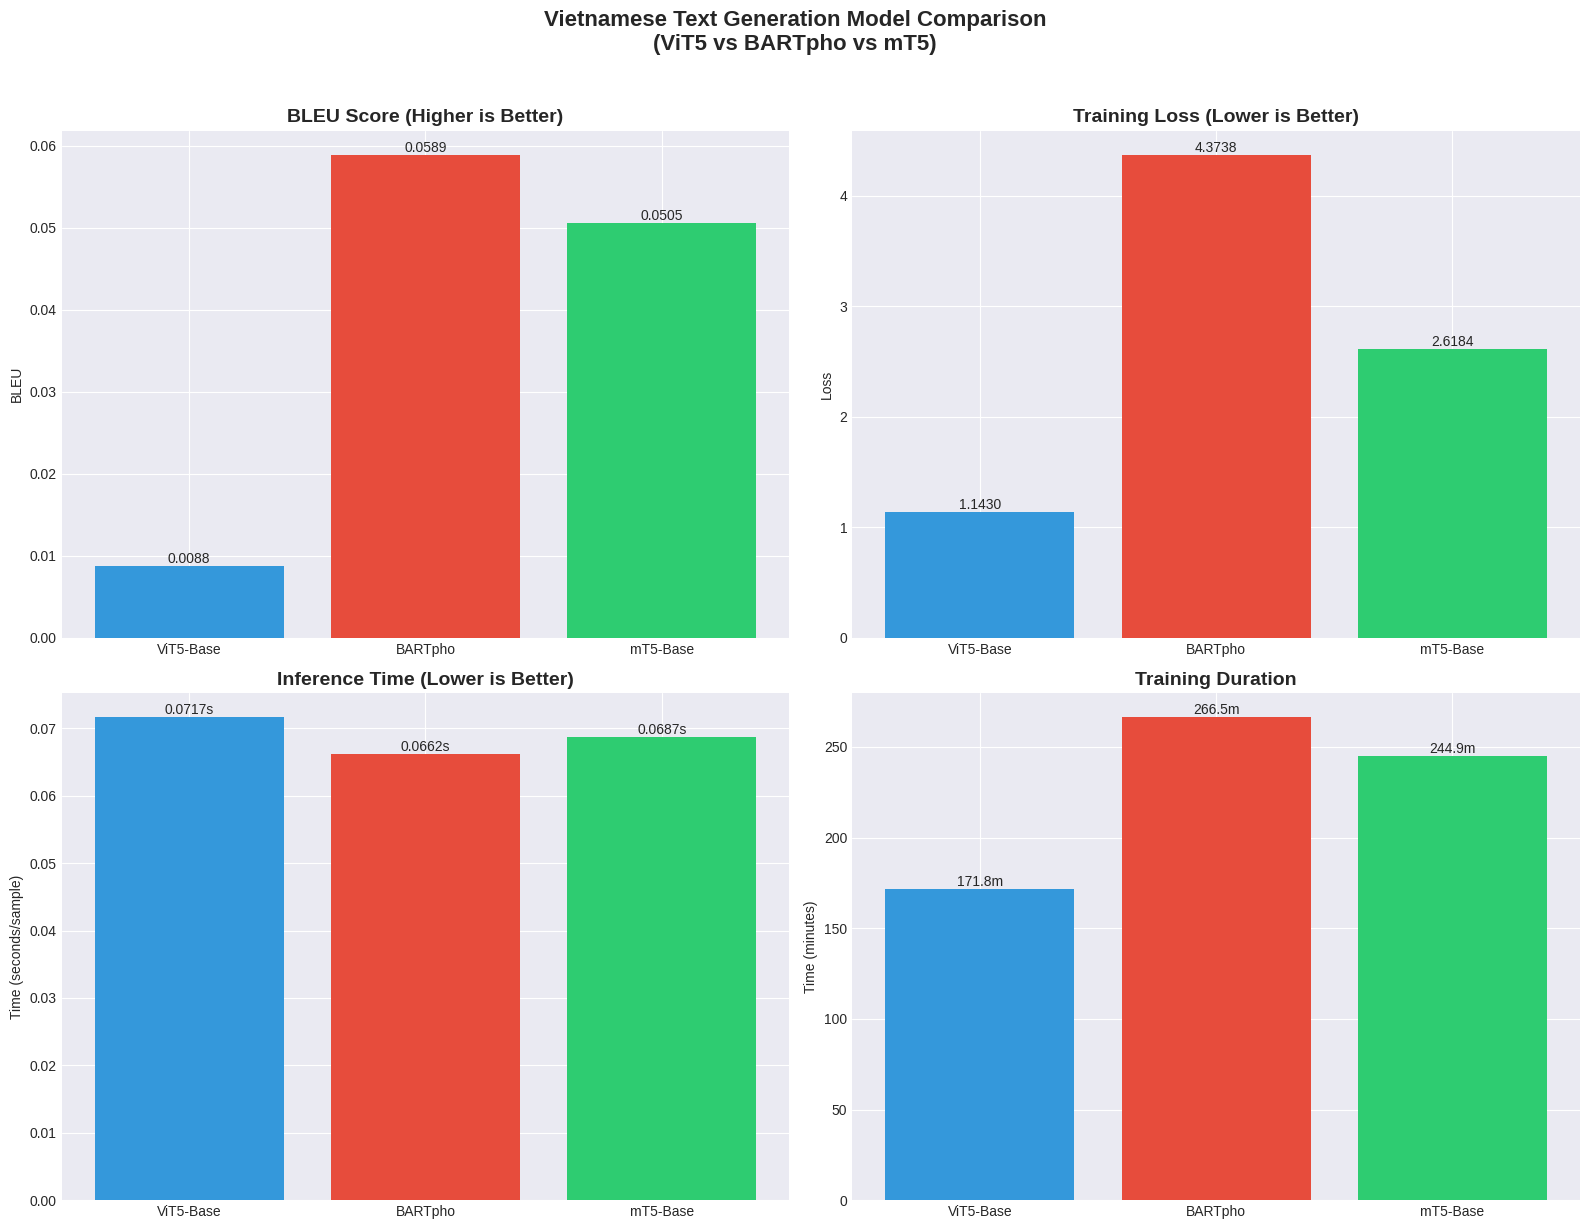


📊 MODEL COMPARISON SUMMARY

┌─────────────────┬───────────────────────────────────────────┬─────────────────────────────────────┐
│     Model       │              Strengths                    │            Best For                 │
├─────────────────┼───────────────────────────────────────────┼─────────────────────────────────────┤
│ ViT5-Base       │ Vietnamese-specific + Custom architecture │ Complex Vietnamese generation       │
│ (Advanced)      │ BiLSTM/RNN/Attention ensemble            │ When quality > speed                │
├─────────────────┼───────────────────────────────────────────┼─────────────────────────────────────┤
│ BARTpho         │ Native Vietnamese pre-training            │ Vietnamese NLP tasks                │
│                 │ Syllable-level tokenization              │ Balanced speed & quality            │
├─────────────────┼───────────────────────────────────────────┼─────────────────────────────────────┤
│ mT5-Base        │ Multilingual capability            

In [9]:
# %%
# ========================================
# CELL 9: FINAL COMPARISON & VISUALIZATION
# ========================================

# Compile results
results_df = pd.DataFrame({
    "Model": ["ViT5-Base", "BARTpho", "mT5-Base"],
    "Architecture": [
        "T5 Enc-Dec + Advanced (BiLSTM/RNN/Attn)",
        "BART Enc-Dec (Vietnamese)",
        "mT5 Enc-Dec Vanilla"
    ],
    "Params": ["220M + custom", "140M", "580M"],
    "Train Loss": [
        result1.metrics['train_loss'],
        result2.metrics['train_loss'],
        result3.metrics['train_loss']
    ],
    "BLEU Score": [
        metrics1['bleu'],
        metrics2['bleu'],
        metrics3['bleu']
    ],
    "Inference Time (s)": [
        metrics1['inference_time'],
        metrics2['inference_time'],
        metrics3['inference_time']
    ],
    "Training Time (min)": [
        result1.metrics['train_runtime'] / 60,
        result2.metrics['train_runtime'] / 60,
        result3.metrics['train_runtime'] / 60
    ]
})

print("\n" + "=" * 100)
print("🏆 FINAL COMPARISON - 3 VIETNAMESE MODELS")
print("=" * 100)
print(results_df.to_string(index=False))
print("=" * 100)

# Save results
results_df.to_csv(f"{config.OUTPUT_DIR}/comparison_results.csv", index=False)

# Best model
best_idx = results_df['BLEU Score'].idxmax()
print(f"\n🥇 BEST MODEL: {results_df.loc[best_idx, 'Model']}")
print(f"   Architecture: {results_df.loc[best_idx, 'Architecture']}")
print(f"   BLEU: {results_df.loc[best_idx, 'BLEU Score']:.4f}")

# Sample predictions
print("\n" + "=" * 100)
print("📝 SAMPLE PREDICTIONS")
print("=" * 100)

for i in range(min(5, len(metrics1['predictions']))):
    print(f"\n{'─' * 100}")
    print(f"Example {i+1}")
    print(f"{'─' * 100}")
    print(f"Reference:\n  {metrics1['references'][i]}")
    print(f"\nViT5-Base (Advanced):\n  {metrics1['predictions'][i]}")
    print(f"\nBARTpho (Vietnamese):\n  {metrics2['predictions'][i]}")
    print(f"\nmT5-Base (Vanilla):\n  {metrics3['predictions'][i]}")

# Visualization
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

colors = ['#3498db', '#e74c3c', '#2ecc71']

# 1. BLEU Score
ax1 = axes[0, 0]
bars = ax1.bar(results_df['Model'], results_df['BLEU Score'], color=colors)
ax1.set_title('BLEU Score (Higher is Better)', fontsize=14, fontweight='bold')
ax1.set_ylabel('BLEU')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# 2. Training Loss
ax2 = axes[0, 1]
bars = ax2.bar(results_df['Model'], results_df['Train Loss'], color=colors)
ax2.set_title('Training Loss (Lower is Better)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Loss')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# 3. Inference Speed
ax3 = axes[1, 0]
bars = ax3.bar(results_df['Model'], results_df['Inference Time (s)'], color=colors)
ax3.set_title('Inference Time (Lower is Better)', fontsize=14, fontweight='bold')
ax3.set_ylabel('Time (seconds/sample)')
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}s', ha='center', va='bottom', fontsize=10)

# 4. Training Time
ax4 = axes[1, 1]
bars = ax4.bar(results_df['Model'], results_df['Training Time (min)'], color=colors)
ax4.set_title('Training Duration', fontsize=14, fontweight='bold')
ax4.set_ylabel('Time (minutes)')
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}m', ha='center', va='bottom', fontsize=10)

plt.suptitle('Vietnamese Text Generation Model Comparison\n(ViT5 vs BARTpho vs mT5)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f"{config.OUTPUT_DIR}/comparison_charts.png", dpi=300, bbox_inches='tight')
plt.show()

# Summary table
print("\n" + "=" * 100)
print("📊 MODEL COMPARISON SUMMARY")
print("=" * 100)
print(f"""
┌─────────────────┬───────────────────────────────────────────┬─────────────────────────────────────┐
│     Model       │              Strengths                    │            Best For                 │
├─────────────────┼───────────────────────────────────────────┼─────────────────────────────────────┤
│ ViT5-Base       │ Vietnamese-specific + Custom architecture │ Complex Vietnamese generation       │
│ (Advanced)      │ BiLSTM/RNN/Attention ensemble            │ When quality > speed                │
├─────────────────┼───────────────────────────────────────────┼─────────────────────────────────────┤
│ BARTpho         │ Native Vietnamese pre-training            │ Vietnamese NLP tasks                │
│                 │ Syllable-level tokenization              │ Balanced speed & quality            │
├─────────────────┼───────────────────────────────────────────┼─────────────────────────────────────┤
│ mT5-Base        │ Multilingual capability                   │ When need multilingual support      │
│                 │ Large-scale pre-training                  │ Transfer learning                   │
└─────────────────┴───────────────────────────────────────────┴─────────────────────────────────────┘
""")

print(f"\n✅ Charts saved to: {config.OUTPUT_DIR}/comparison_charts.png")
print(f"✅ Results saved to: {config.OUTPUT_DIR}/comparison_results.csv")
print(f"\n🎉 ALL DONE! Check results in: {config.OUTPUT_DIR}")


# %%
# ========================================
# CELL 10: QUICK INFERENCE DEMO (Optional)
# ========================================

def demo_inference(model_path, tokenizer_path, model_type, test_texts):
    """Demo inference với model đã train"""
    
    print(f"\n{'=' * 70}")
    print(f"🎯 DEMO INFERENCE: {model_type}")
    print(f"{'=' * 70}")
    
    if model_type == "bartpho":
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
        model = AutoModelForSeq2SeqLM.from_pretrained(
            model_path, torch_dtype=torch.bfloat16
        ).to("cuda")
    elif model_type == "mt5":
        tokenizer = MT5Tokenizer.from_pretrained(tokenizer_path)
        model = MT5ForConditionalGeneration.from_pretrained(
            model_path, torch_dtype=torch.bfloat16
        ).to("cuda")
    else:  # vit5
        tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)
        model = T5ForConditionalGeneration.from_pretrained(
            model_path, torch_dtype=torch.bfloat16
        ).to("cuda")
    
    model.eval()
    
    for text in test_texts:
        inputs = tokenizer(text, return_tensors="pt", max_length=128, truncation=True).to("cuda")
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_length=64,
                num_beams=4,
                early_stopping=True
            )
        
        result = tokenizer.decode(outputs[0], skip_special_tokens=True)
        print(f"\nInput: {text[:100]}...")
        print(f"Output: {result}")
    
    del model
    torch.cuda.empty_cache()


# Demo với một vài test cases
demo_texts = [
    "<TIKTOK> video này hay quá đi mất",
    "<FACEBOOK> sản phẩm tốt lắm shop ơi",
    "<YOUTUBE> clip rất hữu ích cảm ơn bạn"
]

# Uncomment để chạy demo
# demo_inference(f"{config.OUTPUT_DIR}/bartpho/final", f"{config.OUTPUT_DIR}/bartpho/final", "bartpho", demo_texts)
# demo_inference(f"{config.OUTPUT_DIR}/mt5-base/final", f"{config.OUTPUT_DIR}/mt5-base/final", "mt5", demo_texts)

print("\n🎉 Script completed successfully!")